**housekeeping and load data**

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import zipfile
import os

In [8]:
#path to the uploaded zip file
zip_path = os.path.join(os.getcwd(), "cats.zip")

#directory to extract the contents to
extract_path = os.path.join(os.getcwd(), "cats")

#make the dir
os.mkdir(extract_path)

#extract the contents of the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [9]:
#load data as tf dataset

ds = tf.keras.utils.image_dataset_from_directory(extract_path, label_mode=None, image_size=(64,64), batch_size=128)

Found 15747 files belonging to 1 classes.


In [ ]:
#sanity check
for batch in ds.take(1):
    for i in range(1):
        print("Batch shape:", batch.shape)
        print("Batch elements:")
        for element in batch:
          print(element)

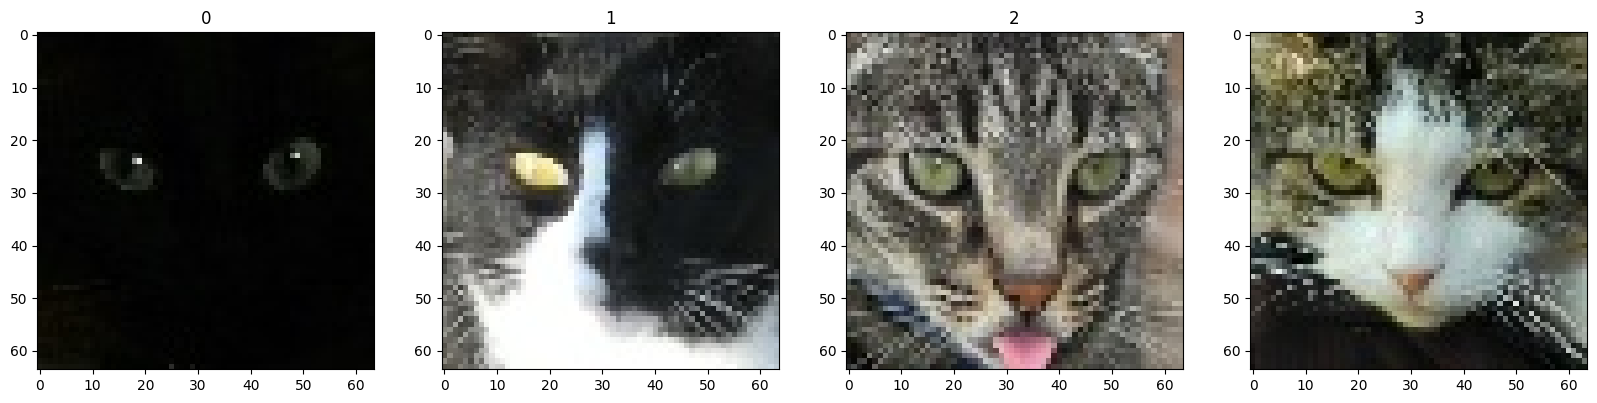

In [11]:
#test display 4 images
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for images in ds.take(1):
    for i in range(4):
        ax[i].imshow(images[i].numpy().astype("uint8"))
        ax[i].title.set_text(i)

In [12]:
#scale images
def scale(image):
    return image/255.0

#map, cache, prefetch
ds = ds.map(scale)
ds = ds.cache()
ds = ds.prefetch(tf.data.AUTOTUNE)

**build model**

In [14]:
#import model and layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape, LeakyReLU, BatchNormalization

*build generator*

In [15]:
from tensorflow.keras import layers
def make_generator():
    model = tf.keras.Sequential()

    #input layer
    model.add(Dense(4 * 4 * 512, use_bias=False, input_dim=100))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Reshape((4, 4, 512)))

    #upsampling blocks
    model.add(Conv2DTranspose(256, 5, strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(128, 5, strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(128, 5, strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(64, 5, strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(3, 5, padding='same', use_bias=False, activation='tanh'))

    return model

In [16]:
generator = make_generator()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              819200    
                                                                 
 batch_normalization_5 (Bat  (None, 8192)              32768     
 chNormalization)                                                
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 8, 8, 256)         3276800   
 Transpose)                                                      
                                                                 
 batch_normalization_6 (Bat  (None, 8, 8, 256)        

1/1 [==============================] - 0s 169ms/step


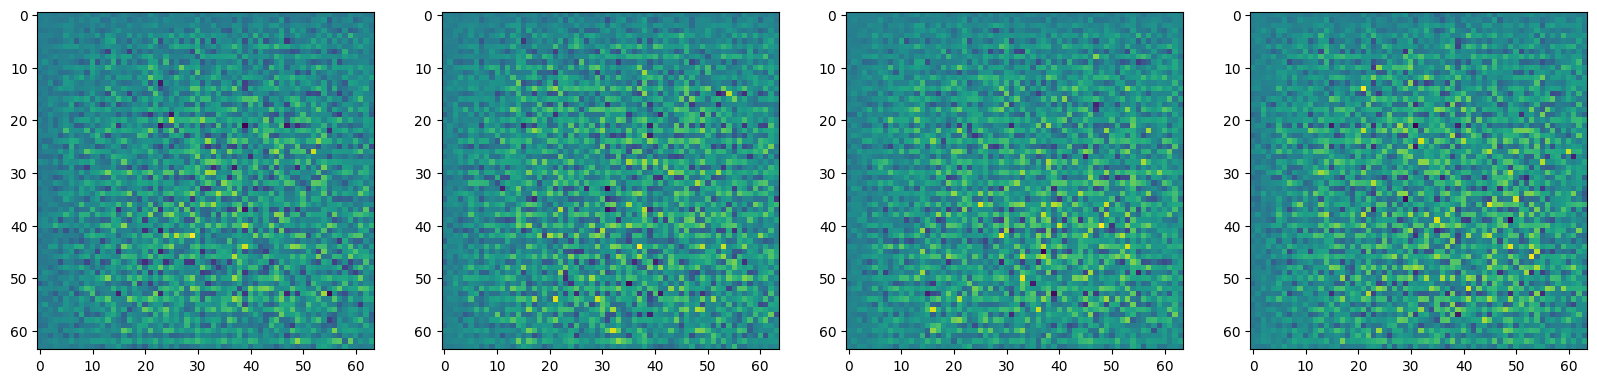

In [17]:
#test generate image
img = generator.predict(tf.random.normal([4, 100]))

#setup subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(img):
  ax[idx].imshow(img[:,:,0])

*build discriminator*

In [76]:
def make_discriminator():
    model = tf.keras.Sequential()

    model.add(Conv2D(64, 5, strides=(2, 2), padding='same', input_shape=[64, 64, 3]))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(64, 5, strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(128, 5, strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(256, 5, strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(256, 5, strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))


    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [77]:
discriminator = make_discriminator()
discriminator.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 32, 32, 64)        4864      
                                                                 
 batch_normalization_32 (Ba  (None, 32, 32, 64)        256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_23 (Conv2D)          (None, 16, 16, 64)        102464    
                                                                 
 batch_normalization_33 (Ba  (None, 16, 16, 64)        256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_33 (LeakyReLU)  (None, 16, 16, 64)       

In [84]:
#test predict
discriminator.predict(np.expand_dims(img,0))

1/1 [==============================] - 0s 227ms/step


array([[0.49999082]], dtype=float32)

**make custom training loop**

In [85]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [86]:
d_opt = Adam(learning_rate=3e-4)
g_opt = Adam(learning_rate=3e-4)
loss = BinaryCrossentropy()

In [87]:
from tensorflow.keras.models import Model

In [88]:
class CatGAN(Model):
  def __init__(self, generator, discriminator, *args, **kwargs):
    #pass through args and kwargs to base class
    super().__init__(*args, **kwargs)

    #create attributes for gen and disc
    self.generator = generator
    self.discriminator = discriminator

  def compile(self, d_opt, g_opt, loss, *args, **kwargs):
    #compile with base class
    super().compile(*args, **kwargs)

    #create attributes for losses and optimizers
    self.d_opt = d_opt
    self.g_opt = g_opt
    self.loss = loss


  def train_step(self, images):
    noise = tf.random.normal([128, 100])

    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
      #generate random noise
      fake_images = self.generator(noise, training=True)

      real = self.discriminator(images, training=True)
      fake = self.discriminator(fake_images, training=True)

      #calculate loss of generator
      total_g_loss = self.loss(tf.ones_like(fake), fake)
      #calculate loss of discriminator
      real_d_loss = self.loss(tf.ones_like(real), real)
      fake_d_loss = self.loss(tf.zeros_like(fake), fake)
      total_d_loss = real_d_loss + fake_d_loss

    #backprop
    g_grad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
    d_grad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)

    self.g_opt.apply_gradients(zip(g_grad, self.generator.trainable_variables))
    self.d_opt.apply_gradients(zip(d_grad, self.discriminator.trainable_variables))

    return {'d_loss':total_d_loss, 'g_loss':total_g_loss}

In [89]:
#create instance of subclassed model
catgan = CatGAN(generator, discriminator)

In [90]:
#compile the model
catgan.compile(d_opt, g_opt, loss)

build callback

In [91]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [92]:
#save examples of image during training
class ModelMonitor(Callback):
  def __init__(self, num_img=1, latent_dim=100):
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs=None):
    random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()
    for i in range(self.num_img):
      img = array_to_img(generated_images[i])
      img.save(os.path.join("images", f"generated_img_{epoch}_{i}.png"))


train

In [93]:
hist = catgan.fit(ds, epochs=300, callbacks=[ModelMonitor()])

Epoch 1/300
124/124 [==============================] - 13s 66ms/step - d_loss: 0.1267 - g_loss: 6.1621
Epoch 2/300
124/124 [==============================] - 8s 64ms/step - d_loss: 0.0284 - g_loss: 9.8844
Epoch 3/300
124/124 [==============================] - 8s 64ms/step - d_loss: 0.2066 - g_loss: 7.0522
Epoch 4/300
124/124 [==============================] - 8s 64ms/step - d_loss: 0.1558 - g_loss: 4.8195
Epoch 5/300
124/124 [==============================] - 8s 64ms/step - d_loss: 0.0418 - g_loss: 5.9491
Epoch 6/300
124/124 [==============================] - 8s 65ms/step - d_loss: 0.1839 - g_loss: 5.6698
Epoch 7/300
124/124 [==============================] - 8s 64ms/step - d_loss: 0.0532 - g_loss: 5.7099
Epoch 8/300
124/124 [==============================] - 8s 64ms/step - d_loss: 0.1007 - g_loss: 5.3006
Epoch 9/300
124/124 [==============================] - 8s 65ms/step - d_loss: 0.1288 - g_loss: 5.9943
Epoch 10/300
124/124 [==============================] - 8s 64ms/step - d_loss: 0.

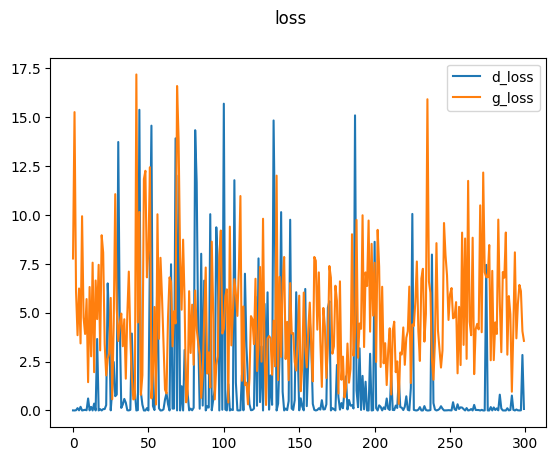

In [97]:
plt.suptitle("loss")
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

**test out generator**

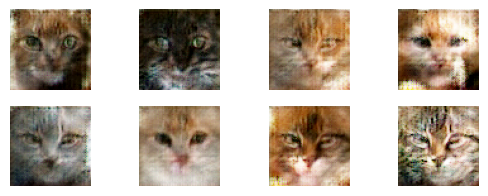

In [111]:
imgs = generator(tf.random.normal([8,100]), training=False)
for i in range(imgs.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(imgs[i])
    plt.axis('off')

In [ ]:
generator.save("generator.h5")
discriminator.save("discriminator.h5")